In [2]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock


In [3]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

sns.set_style("whitegrid")


In [4]:
# block function from pyblock package -  https://github.com/jsspencer/pyblock
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr


def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error


def Kd_calc(bound, conc):
    return((1-bound)*conc/bound)


def get_blockerrors(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        be = block(data)**.5
        ave.append(np.average(data))
        block_errors.append(be)
    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac

    return ave_bf, be_bf


def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf


def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be


def get_blockerror_pyblock(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


In [5]:
def calc_SA(trj, helix, start, stop):
    r0 = .10
    RMS_start = start
    RMS_stop = stop
    RMS = []
    for i in range(RMS_start, RMS_stop):
        sel = helix.topology.select("residue %s to %s and name CA" % (i, i+6))
        rmsd = md.rmsd(trj, helix, atom_indices=sel)
        RMS.append(rmsd)
    RMS = np.asarray(RMS)
    Sa_sum = np.zeros((trj.n_frames))
    Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
    return Sa


def calc_Rg(trj):
    mass = []
    for at in trj.topology.atoms:
        mass.append(at.element.mass)
    mass_CA = len(mass)*[0.0]
    for i in trj.topology.select("name CA"):
        mass_CA[i] = 1.0
    rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
    return rg_CA


def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_reweight(a, b, T, y0, ymax, x0, xmax, weight):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=weight)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges


def free_energy_1D_noscale(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    free_energy = np.log(free_energy+.000001)
    free_energy = -(0.001987*T)*free_energy
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def free_energy_1D_reweight(a, T, x0, xmax, bins, weight):
    free_energy, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=weight)
    max = np.max(free_energy)
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*(free_energy-np.log(max+.0000001))
    xcenters = xedges[:-1] + np.diff(xedges)/2
    return free_energy, xcenters


def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E


def calc_phipsi(trj):
    indices_phi, phis = md.compute_phi(trj)
    indices_psi, psis = md.compute_psi(trj)
    phi_label = []
    for i_phi in range(0, indices_phi.shape[0]):
        resindex = trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
        phi_label.append(resindex)
    phi_label = np.array(phi_label)
    psi_label = []
    for i_psi in range(0, indices_psi.shape[0]):
        resindex = trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
        psi_label.append(resindex)
    psi_label = np.array(psi_label)
    phipsi = []
    for i in range(0, len(phi_label)-1):
        current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
        phipsi.append(current_phipsi)
    phipsi_array = np.array(phipsi)
    return(phipsi_array, psi_label, phi_label)


In [6]:
outdir = './R2_R3_APO/'
pdb = './Trajectory_File_9.27.22/Tau5R2R3_apo.pdb'
rep0 = './Trajectory_File_9.27.22/Tau5R2R3_apo.xtc'
helixpdb = './Trajectory_File_9.27.22/R2R3_all_helix.pdb'

print("outdir:", outdir)
print("pdb:", pdb)
print("helix pdb:", helixpdb)
print("trjaectory:", rep0)


outdir: ./R2_R3_APO/
pdb: ./Trajectory_File_9.27.22/Tau5R2R3_apo.pdb
helix pdb: ./Trajectory_File_9.27.22/R2R3_all_helix.pdb
trjaectory: ./Trajectory_File_9.27.22/Tau5R2R3_apo.xtc


In [7]:
trj = md.load(rep0, top=pdb, stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames
sim_length = trj.time/1000*80/1000
sim_length = sim_length[-1]

In [8]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

residues = 58
residue_offset = 390
prot_res_renum = np.asarray(prot_res)+residue_offset
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:", residue_number)


** SYSTEM INFO **

Number of atoms: 739

Number of residues: 58

Number of protein residues: 57

Number of frames: 57144

Starting frame: 0

Last frame: 57144

sequence:  [ACE0, LEU1, ASP2, TYR3, GLY4, SER5, ALA6, TRP7, ALA8, ALA9, ALA10, ALA11, ALA12, GLN13, CYS14, ARG15, TYR16, GLY17, ASP18, LEU19, ALA20, SER21, LEU22, HIS23, GLY24, ALA25, GLY26, ALA27, ALA28, GLY29, PRO30, GLY31, SER32, GLY33, SER34, PRO35, SER36, ALA37, ALA38, ALA39, SER40, SER41, SER42, TRP43, HIS44, THR45, LEU46, PHE47, THR48, ALA49, GLU50, GLU51, GLY52, GLN53, LEU54, TYR55, GLY56, NH257]

residue names:  ['ACE', 'LEU', 'ASP', 'TYR', 'GLY', 'SER', 'ALA', 'TRP', 'ALA', 'ALA', 'ALA', 'ALA', 'ALA', 'GLN', 'CYS', 'ARG', 'TYR', 'GLY', 'ASP', 'LEU', 'ALA', 'SER', 'LEU', 'HIS', 'GLY', 'ALA', 'GLY', 'ALA', 'ALA', 'GLY', 'PRO', 'GLY', 'SER', 'GLY', 'SER', 'PRO', 'SER', 'ALA', 'ALA', 'ALA', 'SER', 'SER', 'SER', 'TRP', 'HIS', 'THR', 'LEU', 'PHE', 'THR', 'ALA', 'GLU', 'GLU', 'GLY', 'GLN', 'LEU', 'TYR', 'GLY', 'NH2']

residue

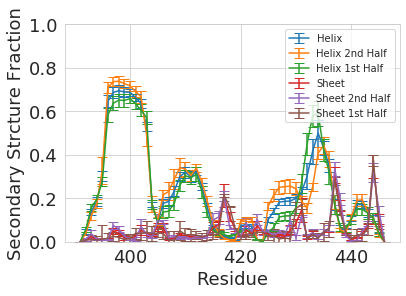

In [9]:
trjH1 = md.load(rep0, top=pdb, stride=1)
H1 = top.select("resid 1 to 56")
trjH1.restrict_atoms(H1)
trjH1.center_coordinates()
frames = trjH1.n_frames
half = int(np.floor(frames/2))

h_res = []
for res in trjH1.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
residue_offset = 390
hres_renum = np.asarray(h_res)+residue_offset


frames = trj.n_frames
half = int(np.floor(frames/2))

dsspH1 = md.compute_dssp(trjH1, simplified=True)
dsspH1_h2 = md.compute_dssp(trjH1[half:-1], simplified=True)
dsspH1_h1 = md.compute_dssp(trjH1[0:half], simplified=True)

H1_H, H1_E = dssp_convert(dsspH1)
H1_H_h2, H1_E_h2 = dssp_convert(dsspH1_h2)
H1_H_h1, H1_E_h1 = dssp_convert(dsspH1_h1)

plt.errorbar(hres_renum, H1_H[:, 0], yerr=H1_H[:, 1], capsize=5, label='Helix')
plt.errorbar(
    hres_renum, H1_H_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Helix 2nd Half')
plt.errorbar(
    hres_renum, H1_H_h1[:, 0], yerr=H1_H_h1[:, 1], capsize=5, label='Helix 1st Half')
plt.errorbar(hres_renum, H1_E[:, 0], yerr=H1_E[:, 1], capsize=5, label='Sheet')
plt.errorbar(
    hres_renum, H1_E_h1[:, 0], yerr=H1_E_h1[:, 1], capsize=5, label='Sheet 2nd Half')
plt.errorbar(
    hres_renum, H1_E_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Sheet 1st Half')

plt.ylim(0, 1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt(outdir+'Hprop.err.dat',
           np.column_stack((hres_renum, H1_H[:, 0], H1_H[:, 1])))
np.savetxt(outdir+'Eprop.err.dat',
           np.column_stack((hres_renum, H1_E[:, 0], H1_E[:, 1])))


In [10]:
dsspH = np.copy(dsspH1)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
np.shape(dsspH1)
TotalH
print("Average Helical Residues:%6.3lf" %
      (np.average(TotalH)), "+_%6.3lf" % ((block(TotalH)**.5)))
print("Average Fraction Helix:%6.3lf" %
      (np.average(TotalH)/56.0), "+_%6.3lf" % ((block(TotalH)**.5)/56.0))


Average Helical Residues:13.062 +_ 0.364
Average Fraction Helix: 0.233 +_ 0.006


In [11]:
# Compute Phi and Psi
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
phi_label = []
for i_phi in range(0, indices_phi.shape[0]):
    resindex = trj.topology.atom(indices_phi[i_phi][3]).residue.resSeq
    phi_label.append(resindex)
phi_label = np.array(phi_label)
psi_label = []
for i_psi in range(0, indices_psi.shape[0]):
    resindex = trj.topology.atom(indices_psi[i_psi][3]).residue.resSeq
    psi_label.append(resindex)
psi_label = np.array(psi_label)
phipsi = []
for i in range(0, len(psi_label)-1):
    current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
    phipsi.append(current_phipsi)
phipsi_array = np.array(phipsi)


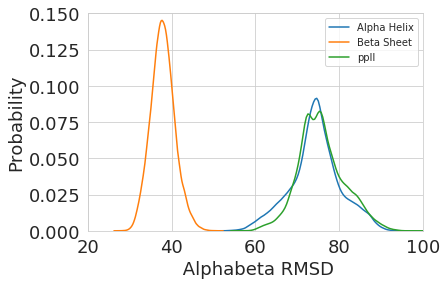

<Figure size 432x288 with 0 Axes>

In [12]:
def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


Phi_all = phis
Psi_all = psis
alphabeta_alpharight = alphabeta_rmsd(Phi_all, Psi_all, -1.05, -0.79)
alphabeta_betasheet = alphabeta_rmsd(Phi_all, Psi_all, 2.36, -2.36)
alphabeta_ppII = alphabeta_rmsd(Phi_all, Psi_all, -1.31, 2.71)

sns.kdeplot(data=alphabeta_alpharight, label='Alpha Helix')
sns.kdeplot(data=alphabeta_betasheet, label='Beta Sheet')
sns.kdeplot(data=alphabeta_ppII, label='ppII')

plt.xlabel(' Alphabeta RMSD', fontsize=18)
plt.xlim(20, 100)
plt.ylim(0, 0.15)

plt.ylabel('Probability', fontsize=18)
plt.legend(loc='upper right')
plt.tick_params(labelsize=18)

plt.show()
plt.savefig(outdir+'Alphabeta.histogram.png')


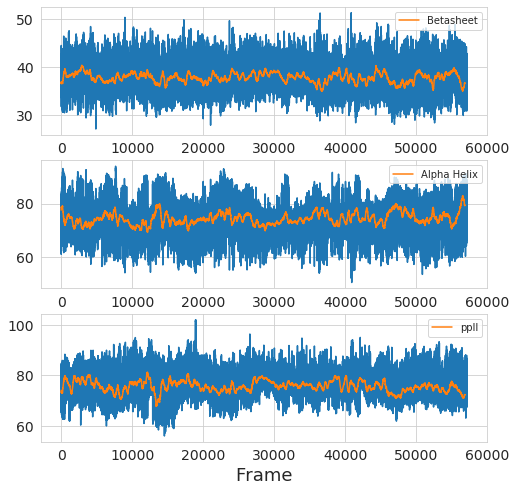

In [13]:
fig, ax = plt.subplots(3, figsize=((8, 8)))
N = 300
ax[0].plot(alphabeta_betasheet)
ax[0].plot(np.convolve(alphabeta_betasheet, np.ones(
    N)/N, mode='valid'), label='Betasheet')
ax[0].legend(loc='upper right')

ax[1].plot(alphabeta_alpharight)
ax[1].plot(np.convolve(alphabeta_alpharight, np.ones(
    N)/N, mode='valid'), label='Alpha Helix')
ax[1].legend(loc='upper right')

ax[2].plot(alphabeta_ppII)
ax[2].plot(np.convolve(alphabeta_ppII, np.ones(
    N)/N, mode='valid'), label='ppII')
ax[2].legend(loc='upper right')

ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)
ax[2].tick_params(labelsize=14)

plt.xlabel('Frame', size=18)
plt.savefig(outdir+'Alphabeta.timecourse.png')


CA Radius of Gyration: 1.253 +_ 0.008
1st Half CA Radius of Gyration: 1.251 +_ 0.007
2nd Half CA Radius of Gyration: 1.256 +_ 0.015


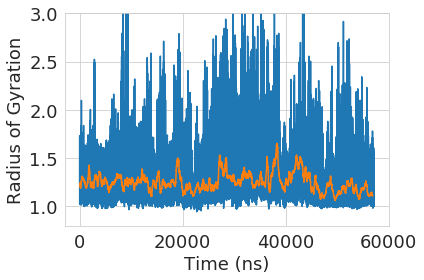

In [14]:
mass = []
for at in trj.topology.atoms:
    mass.append(at.element.mass)
mass_CA = len(mass)*[0.0]
# put the CA entries equal to 1.0
for i in trj.topology.select("name CA"):
    mass_CA[i] = 1.0
# calculate CA radius of gyration
rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
# SE_rg=(block(rg_all))**.5
plt.clf()
plt.plot(rg_CA)
plt.plot(np.convolve(rg_CA, np.ones(N)/N, mode='valid'))
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Radius of Gyration', size=18)
plt.ylim(0.8, 3.0)
plt.tick_params(labelsize=18)
plt.tight_layout()
print("CA Radius of Gyration:%6.3lf" %
      np.average(rg_CA), "+_%6.3lf" % block(rg_CA)**.5)
print("1st Half CA Radius of Gyration:%6.3lf" % np.average(
    rg_CA[0:half]), "+_%6.3lf" % block(rg_CA[0:half])**.5)
print("2nd Half CA Radius of Gyration:%6.3lf" % np.average(
    rg_CA[half:-1]), "+_%6.3lf" % block(rg_CA[half:-1])**.5)

plt.savefig(outdir+'rg.pdf')
np.savetxt(outdir+'rg.dat', rg_CA)


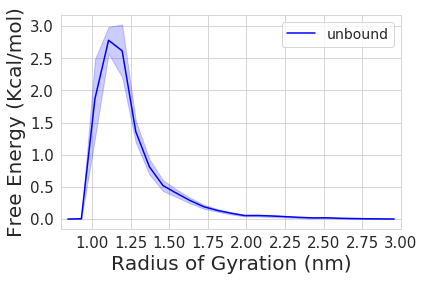

In [15]:
Rg_unbound, edges, u_err = histo_blockerror(rg_CA, 0.8, 3.0, 25, 5)

plt.plot(edges, Rg_unbound, c='blue', label='unbound')
plt.fill_between(edges, Rg_unbound-u_err, Rg_unbound +
                 u_err, color='blue', alpha=0.2)

plt.xlim(0.8, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


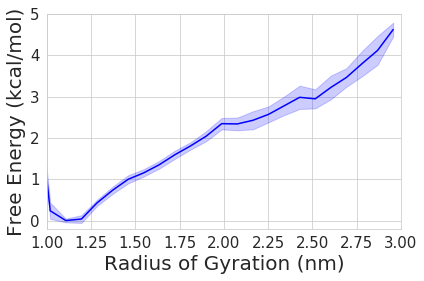

In [16]:
dG, bin_centers, ferr = free_energy_1D_blockerror(rg_CA, 300, 0.8, 3.0, 25, 5)
sns.lineplot(x=bin_centers, y=dG, color='blue')
plt.fill_between(bin_centers, dG-ferr, dG+ferr, color='blue', alpha=0.2)
plt.ylim(-0.2, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
np.savetxt(outdir+'rg.dG.err.dat', np.column_stack((bin_centers, dG, ferr)))
plt.tight_layout()
plt.savefig('%s/Rg.dG.pdf' % outdir)
plt.show()


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


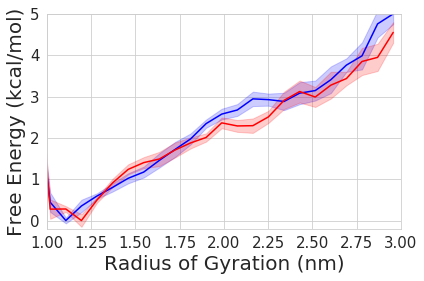

In [17]:
# [0:half],[half:-1]
dG1, bin_centers, ferr = free_energy_1D_blockerror(
    rg_CA[0:half], 300, 0.8, 3.0, 25, 5)
dG2, bin_centers, ferr = free_energy_1D_blockerror(
    rg_CA[half:-1], 300, 0.8, 3.0, 25, 5)
sns.lineplot(x=bin_centers, y=dG1, color='blue')
sns.lineplot(x=bin_centers, y=dG2, color='red')

plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='blue', alpha=0.2)
plt.fill_between(bin_centers, dG2-ferr, dG2+ferr, color='red', alpha=0.2)

plt.ylim(-0.2, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.tight_layout()
plt.savefig('%s/Rg.dG.splithalfs.pdf' % outdir)
plt.show()


Number of residues: 58

Sα: 6.532 +_ 0.133


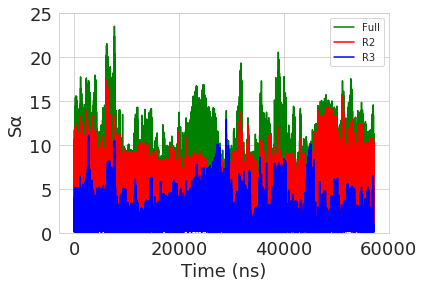

In [18]:
helix = md.load_pdb(helixpdb)
helix
top_helix = helix.topology
backbone_helix = top_helix.select("name CA")
backbone = top.select("name CA")

sel1 = top_helix.select("name CA and residue 1 to 25")
sel2 = top_helix.select("name CA and residue 36 to 56")

print("Number of residues: %d\n" % len(set(nres)))
RMS_start = 1
RMS_stop = 51
RMS = []
for i in range(RMS_start, RMS_stop):
    sel = top_helix.select("residue %s to %s and backbone" % (i, i+6))
    rmsd = md.rmsd(trj, helix, atom_indices=sel)
    RMS.append(rmsd)
RMS = np.asarray(RMS)
RMS

Sa_sum = np.zeros((trj.n_frames))
Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
Sa_ave = np.average(Sa, axis=1)
Sa_total = np.sum(Sa, axis=0)
Sa_R2 = np.sum(Sa[0:25], axis=0)
Sa_R3 = np.sum(Sa[36:56], axis=0)

print("Sα:%6.3lf" % np.average(Sa_total),
      "+_%6.3lf" % block(Sa_total)**.5)

N = 300
plt.plot(Sa_total, label='Full', c='g')
plt.plot(Sa_R2, label='R2', c='r')
plt.plot(Sa_R3, label='R3', c='b')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 25)
plt.savefig(outdir+'Sa.timecourse.png')
np.savetxt(outdir+'Sa_total.dat', Sa_total)
np.savetxt(outdir+'Sa_total.R2.dat', Sa_R2)
np.savetxt(outdir+'Sa_total.R3.dat', Sa_R3)


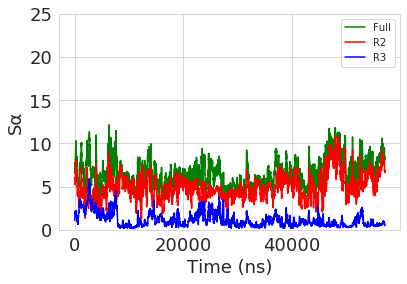

In [19]:
N = 100
plt.plot(np.convolve(Sa_total, np.ones(N)/N, mode='valid'), label='Full', c='g')
plt.plot(np.convolve(Sa_R2, np.ones(N)/N, mode='valid'), label='R2', c='r')
plt.plot(np.convolve(Sa_R3, np.ones(N)/N, mode='valid'), label='R3', c='b')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 25)
plt.savefig(outdir+'Sa.timecourse.smooth.png')


/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


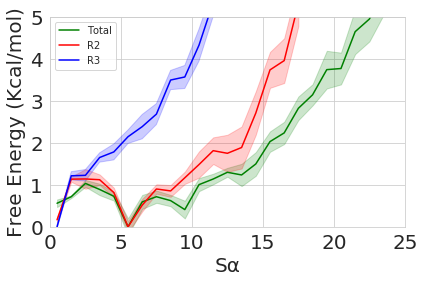

In [20]:
Sa_dg, edges, Sa_err = free_energy_1D_blockerror(Sa_total, 300, 0, 25, 25, 5)
Sa2_dg, edges, Sa2_err = free_energy_1D_blockerror(Sa_R2, 300, 0, 25, 25, 5)
Sa3_dg, edges, Sa3_err = free_energy_1D_blockerror(Sa_R3, 300, 0, 25, 25, 5)

plt.clf()
plt.plot(edges, Sa_dg, c='g', label='Total')
plt.plot(edges, Sa2_dg, c='r', label='R2')
plt.plot(edges, Sa3_dg, c='b', label='R3')
plt.fill_between(edges, Sa_dg-Sa_err, Sa_dg+Sa_err, color='g', alpha=0.2)
plt.fill_between(edges, Sa2_dg-Sa2_err, Sa2_dg+Sa2_err, color='r', alpha=0.2)
plt.fill_between(edges, Sa3_dg-Sa3_err, Sa3_dg+Sa3_err, color='b', alpha=0.2)

plt.legend()

plt.ylim(0, 5)
plt.xlim(0, 25)
plt.xlabel('Sα', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
np.savetxt(outdir+'Sa_dg.dat', np.column_stack((edges, Sa_dg, Sa_err)))
np.savetxt(outdir+'Sa.R2dg.dat', np.column_stack((edges, Sa2_dg, Sa2_err)))
np.savetxt(outdir+'Sa.R3.dg.dat', np.column_stack((edges, Sa3_dg, Sa3_err)))
plt.savefig('%s/Sa.dG.png' % outdir)


In [21]:
rg_v_Sa = np.column_stack((rg_CA, Sa_total))
rg_cutoff = 1.3
collapsed = np.where(rg_v_Sa[:, 0] < rg_cutoff)[0]
Sa_cutoff = 6.0
helical = np.where(rg_v_Sa[:, 1] > Sa_cutoff)[0]
glob_index = np.intersect1d(collapsed, helical)
rg_v_Sa[glob_index]
globule_pop = len(glob_index)/len(rg_v_Sa)
print("Ensemble Globule Pop:", globule_pop, "Non Globule:", 1-globule_pop)
T = 300
glob_rg, glob_rg_be = get_blockerror_pyblock(rg_v_Sa[glob_index][:, 0])
rg, rg_be = get_blockerror_pyblock(rg_v_Sa[:, 0])
print("Rg:", rg, "+_", rg_be)
print("Globule Rg:", glob_rg, "+_", glob_rg_be)

T = 300
print("Free Energy Globule:", -(0.001987*T)*np.log(globule_pop))
print("Free Energy Non-Globule:", -(0.001987*T)*np.log(1-globule_pop))
print("Free Energy Difference:", -(0.001987*T)
      * np.log(globule_pop/(1-globule_pop)))


glob_binary = np.zeros(len(rg_v_Sa))
glob_binary[glob_index] = 1
glob_frac = len(glob_index)/len(glob_binary)
glob_boundfrac, glob_boundfrac_be = get_blockerror_pyblock(glob_binary)
print("Globule Fraction:", glob_boundfrac, "+_", glob_boundfrac_be)
glob_upper = glob_boundfrac+glob_boundfrac_be
non_glob = 1-glob_boundfrac
non_glob_upper = 1-(glob_boundfrac-glob_boundfrac_be)
print("Non Globule Fraction:", 1-glob_boundfrac, "+_", glob_boundfrac_be)
dG_diff = -(0.001987*T)*np.log(globule_pop/(1-globule_pop))
dG_diff_upper = -(0.001987*T)*np.log((globule_pop +
                                      glob_boundfrac_be)/(1-globule_pop-glob_boundfrac_be))
print("Free Energy Difference:", dG_diff, "+_", dG_diff-dG_diff_upper)

Ensemble Globule Pop: 0.4035069298614028 Non Globule: 0.5964930701385972
Rg: 1.2530707495811664 +_ 0.013142333375546461
Globule Rg: 1.1124654221092527 +_ 0.009097345469438694
Free Energy Globule: 0.5409974799186822
Free Energy Non-Globule: 0.30799751117508234
Free Energy Difference: 0.23299996874359982
Globule Fraction: 0.4035069298614028 +_ 0.052440884153455984
Non Globule Fraction: 0.5964930701385972 +_ 0.052440884153455984
Free Energy Difference: 0.23299996874359982 +_ 0.1276888818962408


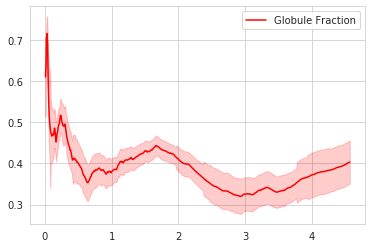

In [22]:
stride = 100
be_by_frame = []
ge_by_frame = []
boundfrac_by_frame = []
globfrac_by_frame = []
bg_pop = []
bg_pop2 = []
bge_by_frame = []
time = np.linspace(0, sim_length, len(glob_binary))
t = []


for i in range(stride, len(glob_binary), stride):
    g_Data = np.asarray(glob_binary[0:i])
    frames = len(g_Data)
    gframes = np.where(g_Data == 1)[0]
    gf, ge = get_blockerror_pyblock_nanskip(g_Data)
    globfrac_by_frame.append(gf)
    ge_by_frame.append(ge)
    t.append(time[i])


plt.plot(t, globfrac_by_frame, label='Globule Fraction', color='red')
plt.fill_between(t, np.asarray(globfrac_by_frame)+np.asarray(ge_by_frame),
                 np.asarray(globfrac_by_frame)-np.asarray(ge_by_frame), color='red', alpha=0.2)
plt.legend(loc='upper right')

np.savetxt(outdir+'glob.frac.be.dat',
           np.column_stack((globfrac_by_frame, ge_by_frame)))


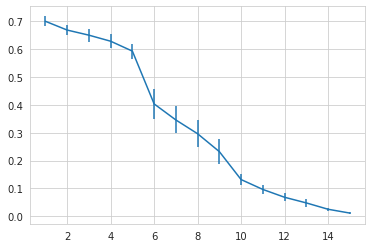

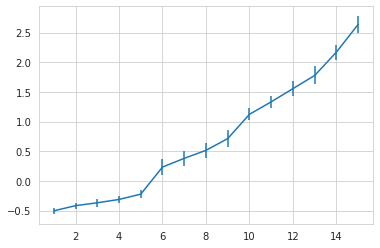

In [23]:
Sa_cut=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
glob_pops=[]
glob_errs=[]
glob_dGs=[]
glob_dGs_err=[]

rg_v_Sa=np.column_stack((rg_CA,Sa_total))
rg_cutoff=1.3
collapsed=np.where(rg_v_Sa[:,0]<rg_cutoff)[0]

for i in Sa_cut:
    Sa_cutoff=i
    helical=np.where(rg_v_Sa[:,1]>Sa_cutoff)[0]
    glob_index=np.intersect1d(collapsed,helical)
    globule_pop=len(glob_index)/len(rg_v_Sa)
    T=300
    glob_binary=np.zeros(len(rg_v_Sa))
    glob_binary[glob_index]=1
    glob_frac=len(glob_index)/len(glob_binary)
    glob_boundfrac,glob_boundfrac_be=get_blockerror_pyblock(glob_binary)
    glob_upper=glob_boundfrac+glob_boundfrac_be
    non_glob=1-glob_boundfrac
    non_glob_upper=1-(glob_boundfrac-glob_boundfrac_be)
    dG_diff=-(0.001987*T)*np.log(globule_pop/(1-globule_pop))
    dG_diff_upper=-(0.001987*T)*np.log((globule_pop+glob_boundfrac_be)/(1-globule_pop-glob_boundfrac_be))
    glob_pops.append(globule_pop)
    glob_errs.append(glob_boundfrac_be)
    glob_dGs.append(dG_diff)
    glob_dGs_err.append(dG_diff-dG_diff_upper)
    
plt.errorbar(Sa_cut,glob_pops,yerr=glob_errs)
plt.show()
plt.clf()
plt.errorbar(Sa_cut,glob_dGs,yerr=glob_dGs_err)
plt.show()

np.savetxt(outdir+'Pop.vs.Sacut.dat',np.column_stack((Sa_cut,glob_pops,glob_errs)))
np.savetxt(outdir+'dGglob.vs.Sacut.dat',np.column_stack((Sa_cut,glob_dGs,glob_dGs_err)))

In [24]:
print(sim_length)

4.5714397


In [25]:

def calc_err(contact_binary, name):
    boundfrac_by_frame = []
    t2 = []
    err_by_frame = []
    err_upper = []
    err_lower = []
    time = np.linspace(0, sim_length, len(rg_CA))
    srtide = 100
    for i in range(stride, len(contact_binary), stride):
        Data = np.asarray(contact_binary[0:i])
        bf, be = get_blockerror_pyblock_nanskip(Data)
        boundfrac_by_frame.append(bf)
        err_by_frame.append(be)
        err_upper.append(bf-be)
        err_lower.append(bf+be)
        t2.append(time[i])

    np.savetxt(outdir + name, np.column_stack((t2, boundfrac_by_frame, err_upper, err_lower)), '%.4f')

calc_err(rg_CA, 'rg.be.dat')
calc_err(Sa_total, 'Sa.be.dat')


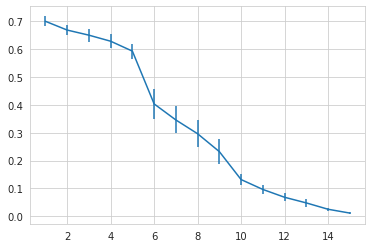

In [26]:
Sa_cut = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
glob_pops = []
glob_errs = []
glob_dGs = []
glob_dGs_err = []

rg_v_Sa = np.column_stack((rg_CA, Sa_total))
rg_cutoff = 1.3
collapsed = np.where(rg_v_Sa[:, 0] < rg_cutoff)[0]

for i in Sa_cut:
    Sa_cutoff = i
    helical = np.where(rg_v_Sa[:, 1] > Sa_cutoff)[0]
    glob_index = np.intersect1d(collapsed, helical)
    globule_pop = len(glob_index)/len(rg_v_Sa)
    T = 300
    glob_binary = np.zeros(len(rg_v_Sa))
    glob_binary[glob_index] = 1
    glob_frac = len(glob_index)/len(glob_binary)
    glob_boundfrac, glob_boundfrac_be = get_blockerror_pyblock(glob_binary)
    #print("Bound Globule Fraction:",glob_boundfrac,"+_",glob_boundfrac_be)
    glob_upper = glob_boundfrac+glob_boundfrac_be
    non_glob = 1-glob_boundfrac
    non_glob_upper = 1-(glob_boundfrac-glob_boundfrac_be)
    #print("Non Globule Fraction:",1-glob_boundfrac,"+_",glob_boundfrac_be)
    dG_diff = -(0.001987*T)*np.log(globule_pop/(1-globule_pop))
    dG_diff_upper = -(0.001987*T)*np.log((globule_pop +
                                          glob_boundfrac_be)/(1-globule_pop-glob_boundfrac_be))
    #print("Free Energy Difference:",dG_diff,"+_",dG_diff-dG_diff_upper)
    glob_pops.append(globule_pop)
    glob_errs.append(glob_boundfrac_be)
    glob_dGs.append(dG_diff)
    glob_dGs_err.append(dG_diff-dG_diff_upper)

plt.errorbar(Sa_cut, glob_pops, yerr=glob_errs)
plt.show()
np.savetxt(outdir+'Pop.vs.Sacut.dat',
           np.column_stack((Sa_cut, glob_pops, glob_errs)))


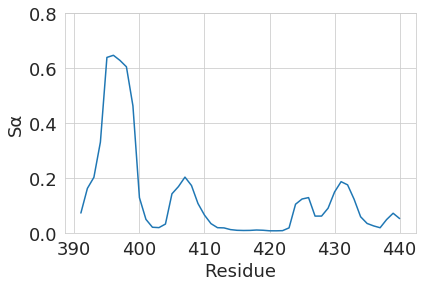

In [27]:
plt.plot(prot_res_renum[1:51], Sa_ave)
plt.xlabel('Residue', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 0.8)
plt.savefig('%s/Sa.ave.png' % outdir)


In [28]:
contact_maps = []
contact_distances = []
for i in range(1, 57):
    contact_map = []
    contact_distance = []
    for j in range(1, 57):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 1.2, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


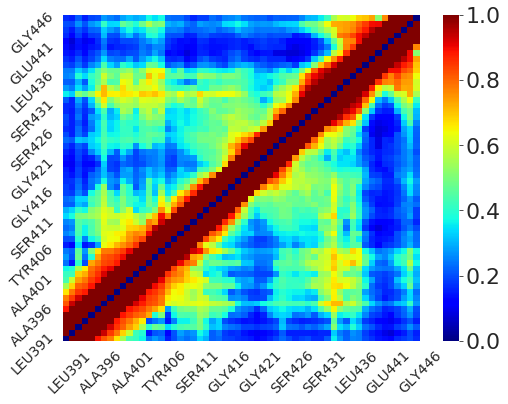

In [29]:
contact_map = final_map
sequence = ['LEU391', '', '', '', '', 'ALA396', '', '', '', '', 'ALA401', '', '', '', '', 'TYR406', '', '', '', '', 'SER411', '', '', '', '', 'GLY416',
            '', '', '', '', 'GLY421', '', '', '', '', 'SER426', '', '', '', '', 'SER431', '', '', '', '', 'LEU436', '', '', '', '', 'GLU441', '', '', '', '', 'GLY446']

# Make distance map
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
im = sns.heatmap(contact_map, cmap='jet', ax=ax)
ax.grid(which='both', alpha=0.5)
plt.xticks(range(1, 57), sequence, rotation=45, size=14)
plt.yticks(range(1, 57), sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
ax.invert_yaxis()


np.savetxt(outdir+'contactmap.dat', final_map)
plt.savefig(outdir+'contact_map.png')
plt.savefig(outdir+'contact_map.pdf')
plt.show()


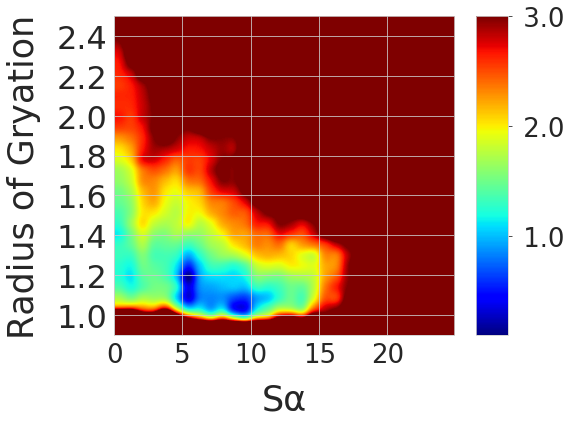

In [30]:
a, xedges, yedges = np.histogram2d(
    rg_CA, Sa_total, 30, [[0.9, 2.5], [0, 25.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
plt.xlim(0, 24.9)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.xlabel("Sα", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')


plt.tight_layout()
np.savetxt(outdir+'Apo.Rg_v_Sa.dG.dat', a)
plt.savefig(outdir+'Apo.Rg_v_Sa.dG.pdf')


<Figure size 432x288 with 0 Axes>

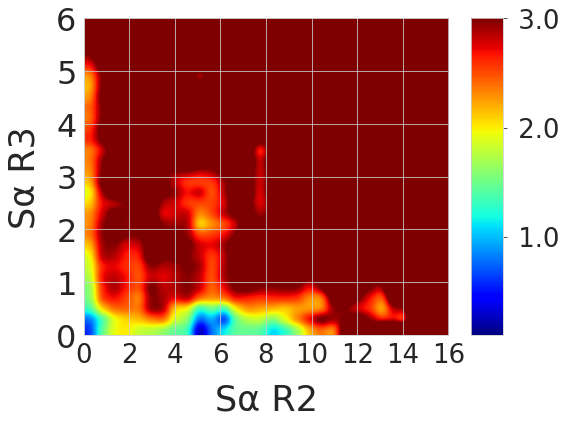

In [31]:
dG, xedges, yedges = free_energy(Sa_R3, Sa_R2, 300, 0, 6.0, 0, 16.0)

# a,xedges,yedges=np.histogram2d(Sa_total_H2,Sa_total_H1,35,[[0,3.5],[0,12]],normed=True,weights=None)
# a=np.log(np.flipud(a)+.000001)
# T=300
# a=-(0.001987*T)*a

plt.clf()
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Sα R3", size=35, labelpad=15)
plt.xlabel("Sα R2", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')

plt.tight_layout()
np.savetxt(outdir+'SaR3_v_SaR2.dg.dat', dG)
plt.savefig(outdir+'R2_v_R3.pdf')


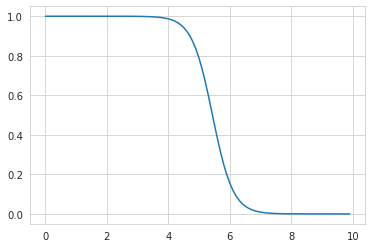

In [32]:
dists = np.arange(0, 10, 0.1)
def sigmoid(x, a, b):
      
    z = np.exp(-(a*x+b))
    sig = 1- 1 / (1 + z)

    return sig
# switch = (1.0-((dists-max)/min)**8)/(1-((dists-max)/min)**12)

plt.plot(dists,sigmoid(dists, 3, -16.3))



[18.763 8.950 18.823 ... 16.833 14.072 13.979]


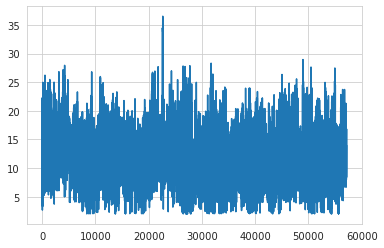

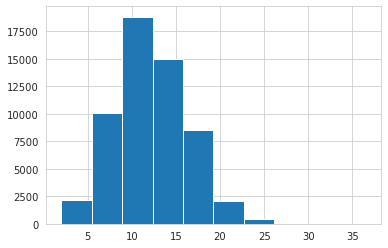

<Figure size 432x288 with 0 Axes>

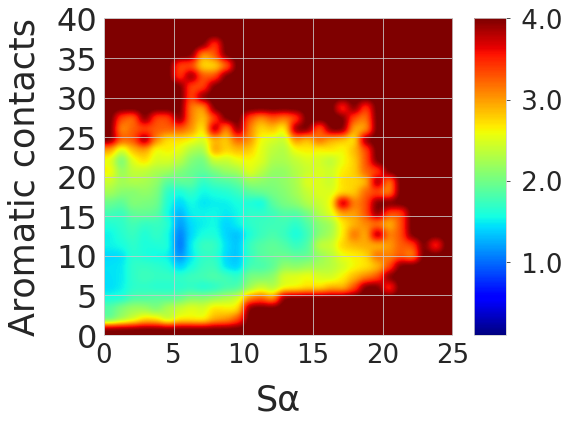

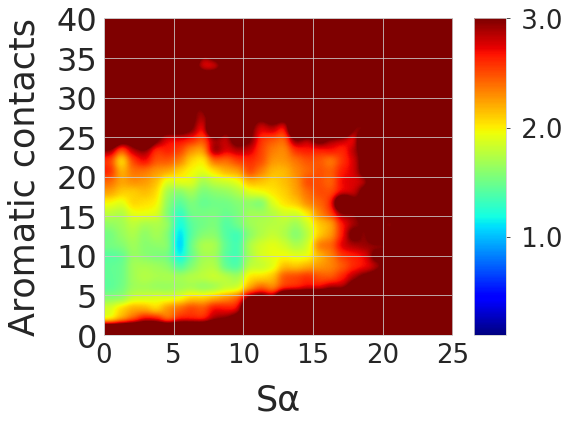

In [33]:
# Protein-protein
# Cut-off 4A, 7A
# 'closest-heavy'
prot_aromatic_res_index = [3, 7, 16, 23, 43, 44, 47, 55]
aromatic_contact_pairs = []
for i in range(len(prot_aromatic_res_index)):
    aromatic_contact_pair = []
    for j in range(len(prot_aromatic_res_index)): 
        pair = [prot_aromatic_res_index[i], prot_aromatic_res_index[j]]
        dist = md.compute_contacts(trj, [pair], scheme='closest-heavy')
        dists = np.asarray(dist[0]).astype(float)
        switch_aro = sigmoid(dists*10, 3, -16.3)
        aromatic_contact_pair.append(switch_aro)
    aromatic_contact_pairs.append(aromatic_contact_pair) 
aromatic_contact_pairs = np.asarray(aromatic_contact_pairs).astype(float)
aromatic_contact_sum = aromatic_contact_pairs.sum(axis = 0).sum(axis = 0)- len(prot_aromatic_res_index)
aromatic_contact_sum = aromatic_contact_sum[:,0]
print(aromatic_contact_sum)
plt.plot(aromatic_contact_sum)
plt.show()
plt.clf()

plt.hist(aromatic_contact_sum)
plt.show()
plt.clf()


dG, xedges, yedges = free_energy(aromatic_contact_sum, Sa_total, 150, 0, 40, 0, 25)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.xlabel("Sα", size=35, labelpad=15)
plt.ylabel("Aromatic contacts", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=4.0)
plt.yticks(size='26')
plt.tight_layout()
# np.savetxt(outdir+'Sa_v_aromatic.dG.dat', dG)
plt.savefig(outdir+'Sa_v_aromatic.pdf')


dG, xedges, yedges = free_energy(aromatic_contact_sum, Sa_total, 150, 0, 40, 0, 25)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.xlabel("Sα", size=35, labelpad=15)
plt.ylabel("Aromatic contacts", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')
plt.tight_layout()
# np.savetxt(outdir+'Sa_v_aromatic.dG.dat', dG)
plt.savefig(outdir+'Sa_v_aromatic.pdf')

In [34]:
Sa_vs_aromatic = np.column_stack((Sa_total, aromatic_contact_sum))
Sa_min = [9, 5, 0]
Sa_max = [10, 6, 2]
aromatic_min = [8, 8, 5]
aromatic_max = [16, 16, 11]
basin = []
for i in range(len(Sa_min)):
    Sa_basin = np.where((Sa_vs_aromatic[:, 0] > Sa_min[i]) & (Sa_vs_aromatic[:, 0] < Sa_max[i]))[0]
    aromatic_basin = np.where((Sa_vs_aromatic[:, 1] > aromatic_min[i]) & (Sa_vs_aromatic[:, 1] < aromatic_max[i]))[0]
    basin_index = np.intersect1d(Sa_basin, aromatic_basin)
    newtraj = trj[basin_index]
    md.Trajectory.save_xtc(newtraj, outdir + 'Sa.aromatic.%s.xtc' % i)
    print(newtraj)
    basin.append(basin_index)
print(basin)

<mdtraj.Trajectory with 4798 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 10320 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 4609 frames, 739 atoms, 58 residues, and unitcells>
[array([   52,    54,    61, ..., 57135, 57136, 57138]), array([  340,   542,   665, ..., 57115, 57120, 57143]), array([   14,    15,    22, ..., 57084, 57093, 57108])]
